In [1]:
from lxml import etree
from dotenv import load_dotenv 
from openai import OpenAI

In [2]:
# Read XSD from 1872.1-2024
with open('app/resources/schema.xsd', 'r') as file:
    schema = file.read()

In [3]:
# Read XSD from 1872.1-2024
with open('app/resources/reza_medium.geojson', 'r') as file:
    geojson = file.read()

In [4]:
# global environment config
load_dotenv('/Users/marcos/.gpt/token.env')
MAX_TOKENS: int = 2000

In [5]:
client = OpenAI()

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a mission planner that generates XML mission plans based on robotic task representation. \
            When asked to generate a mission, create an XML file conformant to the known schema and use the GeoJSON file to provide references in the mission plan for things such as GPS location, tree type, etc. \
            It must be syntactically correct and validate using an XML linter.",
    },
    # context
    {
        "role": "user",
        "content": "This is the schema for which you must generate mission plan XML documents:" + schema
    },
    {
        "role": "assistant",
        "content": "If you have any specific questions or modifications you'd like to discuss regarding this schema, feel free to ask!"
    },
    {
        "role": "user",
        "content": "This is the GeoJSON for which you must generate mission plan XML documents. This is our orchard:" + geojson
    },
    {
        "role": "assistant",
        "content": "Thank you for providing the GeoJSON file. I'll assist you in creating the XML file for your robotic mission plan when you provide your mission."
    },
    # TODO: add context of farm layout so that machine can generate XML with relevant state information
]

In [ ]:
m = "Make a plan to take a picture of every other pistachio tree."
message = {"role": "user", "content": m}

In [ ]:
messages.append(message)

In [ ]:
def ask_gpt(messages):
    return client.chat.completions.create(
        model="gpt-4o", messages=messages, max_tokens=MAX_TOKENS
    )

In [ ]:
completion = ask_gpt(messages)

In [ ]:
with open('output.txt', 'w') as fp:
    fp.write(completion.choices[0].message.content)

In [ ]:
gpt_response = completion.choices[0].message.content

xml_response = gpt_response.split("```xml\n")[1]
xml_response = xml_response.split("```")[0]

In [ ]:
with open('app/gpt_outputs/gpt_example.xml', 'w') as fp:
    fp.write(xml_response)

In [ ]:
def validate_xml(xsd_file, xml_file) -> str:
    try:
        # Parse the XSD file
        with open(xsd_file, 'rb') as schema_file:
            schema_root = etree.XML(schema_file.read())
        schema = etree.XMLSchema(schema_root)

        # Parse the XML file
        with open(xml_file, 'rb') as xml_file:
            xml_doc = etree.parse(xml_file)

        # Validate the XML file against the XSD schema
        schema.assertValid(xml_doc)
        return "XML is valid."

    except etree.XMLSchemaError as e:
        return "XML is invalid: " + str(e)
    except Exception as e:
        return "An error occurred: " + str(e)

In [ ]:
# messages.append(gpt_response)
# Example usage
xsd_file = 'app/resources/schema.xsd'
xml_file = 'app/gpt_outputs/tmpye2i8djg'
ret = validate_xml(xsd_file, xml_file)
print(ret)
# messages.append(ret)

## GeoJSON

In [12]:
text: str = (
    """
{ 
"type": "FeatureCollection",
"features": [
    """
)

gps: str = (
    """
    {{
      "type": "Feature",
      "geometry": {{
        "type": "Point",
        "coordinates": [{}, {}]
      }},
      "properties": {{
        "marker-symbol": "{}-tree"
      }}
    }},"""
)

tree_type: str = "pistachio"
i = 0
dir = True
tree_num = 0

for gps_coord in coors:
    out = gps.format(gps_coord[0], gps_coord[1], tree_type)
    text += out
    i += 1

# with open("resources/reza_waypoints.txt", "r") as fp:
#     for line in fp.readlines():
#         gps_coord = line.split(" ")
#         # only want trees
#         if gps_coord[2] == 0:
#             continue
#         if i % 18 == 0:
#             dir = ~dir
#             tree_num -= 18
#         out = gps.format(gps_coord[0], gps_coord[1], tree_type)
#         text += out
#         i += 1

# remove last comma
text = text[:-1]
text += """  
  ]
}
"""

with open("app/resources/ucm20_2m.geojson", "w") as fp:
    fp.write(text)

## scratchpad

In [1]:
import utm
import json
import geopy.distance
import haversine

ModuleNotFoundError: No module named 'geopy'

In [47]:
geojson_data = {}
with open("app/resources/ucm_graph20.geojsonl", "r") as fp:
    for line in fp:
        data = json.loads(line.strip())
        geojson_data[data['properties']['id']] = data

In [48]:
sol = [0, 2, 7, 18, 19]
# sol = [0, 2, 15, 18, 29]
# sol = [0, 7, 25, 36, 39]
cost = 0
for s in range(len(sol)-1):
    lon1, lat1 = geojson_data[sol[s]]['geometry']['coordinates']
    lon2, lat2 = geojson_data[sol[s+1]]['geometry']['coordinates']
    # cost += geopy.distance.distance((lat1, lon1), (lat2, lon2)).meters
    cost += haversine.haversine((lat1, lon1), (lat2, lon2), unit=haversine.Unit.METERS)

budget: 19.9773073572487

In [49]:
cost

15.615627663377666

In [36]:
lon1, lat1 = geojson_data[19]['geometry']['coordinates']
lon2, lat2 = geojson_data[18]['geometry']['coordinates']
geopy.distance.distance((lat1, lon1), (lat2, lon2)).meters

6.9505996566361725

In [46]:
13.686394049112627 * (2/1.3694051976193413)

19.988815688601008

## GPS conversion

In [6]:
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import utm

In [7]:
with open("app/resources/kml/graph20.kml", "rb") as fp:
    root = etree.parse(fp)

In [8]:
root_e: etree._Element = root.getroot()

In [9]:
ns = "{" + root_e.nsmap[None] + "}"

In [10]:
pms = root_e.find(ns + "Document").findall(ns + "Placemark")

In [11]:
coors = []
for pm in pms:
    coor = pm.find(ns + "Point").find(ns + "coordinates").text.split(',')
    coor = [float(c) for c in coor]
    # print(coor[1])
    # e, n, _, _ = utm.from_latlon(coor[1], coor[0])
    e = coor[0]
    n = coor[1]

    coors.append((e, n))

In [126]:
path = []
with open('path.txt', 'r') as fp:
    for f in fp:
        coor = f.split(',')
        coor = [float(c) for c in coor]
        e, n, _, _ = utm.from_latlon(coor[1], coor[0])

        path.append((e, n))

In [127]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    # start_ind = np.argmin(np.absolute(xdata - position))
    start_ind = 0
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

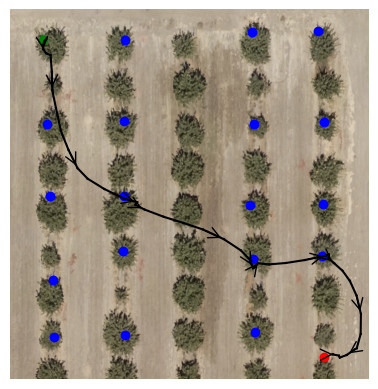

In [136]:
coors = np.array(coors)
path = np.array(path)

img = plt.imread("app/resources/img.png")
fig, ax = plt.subplots()

# ax.imshow(img, extent=[-0.1, 1, -0.3, 1.25])
ax.imshow(img, extent=[np.min(coors[:,0])-0.75, np.max(coors[:,0])+1, np.min(coors[:,1])-0.5, np.max(coors[:,1])+0.5])
# ax.imshow(img, extent=[np.min(coors[:,0]), np.max(coors[:,0]), np.min(coors[:,1]), np.max(coors[:,1])])
# weights = np.arange(0, len(path[20:-29,0]))
for i in range(26, len(path)-11, 1):
    line = plt.plot(path[i:i+2,0], path[i:i+2,1], 'black')[0]
    if i % 4 == 0:
        add_arrow(line, direction='left', color='black', size=20, position=0)
plt.scatter(x = coors[0,0], y = coors[0,1], color='green')
plt.scatter(x = coors[1:-1,0], y = coors[1:-1,1], color='blue')
plt.scatter(x = coors[-1,0], y = coors[-1,1], color='red')
plt.axis('off')
# plt.show()
plt.savefig("test.png",bbox_inches='tight', pad_inches=0.0)